In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import datetime
import pytz
%matplotlib inline

import getpass
password = getpass.getpass()

········


In [2]:
def connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    # Make a query to the specific DB and Collection
    cursor = db[collection].find()
    #print list(cursor)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df.drop("__v", axis=1)

update the local copy of the blockchain

In [3]:
%%bash
cd ~/lbry-explorer
node scripts/sync.js index update

script launched with pid: 63767
{ hash: 'da791f7f82e4071aeb048481decc68bedf672abac093ec57d2314376199f14c1',
  confirmations: 2,
  size: 3384,
  height: 47958,
  version: 536870912,
  versionHex: '20000000',
  merkleroot: 'e5a9e710e8b1d0a170c95cc81d395d34977e639c0c648d0a6b48337ed7e8ddd9',
  nameclaimroot: '0893e57b2deb3e73851a596424d852b1cf82683fdee43ff6fd3dea133b49f8c7',
  tx: 
   [ 'dd5a416b256e5cb8ecc10bc8a957954974f041bd20860f1d95f41cba0169e86c',
     'bf0b5cf4bf6fcfcead93056493957d56d75a4327100acf9763b280b3d12400fa',
     '89258ad8afdaeb84d85da398451498c700da39770c695a26b16e90149a02ddf4',
     '73539b7d308bcdb91047f8015bdcf1cea5dd736ceaa3e4b1bd312ee63e66dced',
     'f10d6e8f33cdd7187bd97e3ab1857baca58255fe8deb26b1d13ec822ae28ea49',
     'd0ef0207cfb08171865a406b4011cdfb8fab706ba1041b0665fe8ff35f8c9144',
     '98a9b4be4b62db6a3f23ea615915863987c0683232c2746069616f13e304df39',
     '4c449ec21a1822f6bf86f2b92f9a9599477ce7961af7d99f1a57bb151b1e4325',
     '704c79fb839eb06c53b9c4907d700

load the transaction data from the local copy of the blockchain

In [4]:
db = "explorerdb"
tx_df = read_mongo(db, "txes", host='localhost', port=27017, username="zargham", password=password)

tz = pytz.timezone('America/Montreal')
tx_df["datetime"] = tx_df.timestamp.map(lambda t: datetime.datetime.fromtimestamp(int(t), tz))

Load dictionary of LBRY business addresses with labels

In [5]:
labels = {"rEQKyb7nd7UUGyEEn5xRkk1fgXdTCf2ZCg": {"label":"LBRY Team", "type":"info", "url":"https://lbry.io/what#credits"},
      "bWbFyN8CJAghwavfRDuEfmv71swkapBcuy": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "rVRMmGLZenVXpT1NwYMGcnwFc642kEgWTV": {"label":"Strategic Partners", "type":"info", "url":"https://lbry.io/what#credits"},
      "bLPbiXBp6Vr3NSnsHzDsLNzoy5o36re9Cz": {"label":"Investor", "type":"info", "url":"https://lbry.io/news/mysterious-100k-lbc-revealed"},
      "rTZF9RvfkLJ6hwCwERwFd7dppRMeddKjpe": {"label":"LBRY Team", "type":"info", "url":"https://lbry.io/what#credits"},
      "bVUrbCK8hcZ5XWti7b9eNxKEBxzc1rr393": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "bHW58d37s1hBjj3wPBkn5zpCX3F8ZW3uWf": {"label":"LBRY Team Escrow (premine)", "type":"info", "url":"https://lbry.io/what#credits"},
      "r9DarmxyPjWkF7ocyxMzaNZN3a9gJvNTZJ": {"label":"Strategic Partners", "type":"info", "url":"https://lbry.io/what#credits"},
      "rMT5Sg8SyFP3ax2PRaweRCRZoMeYw4znEi": {"label":"Adoption Programs", "type":"info", "url":"https://lbry.io/what#credits"},
      "bDzuP6Sawe7tadVKR7dmPW1JFYK9ELnjra": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "bFgohv4wprdCEtW2m5EVQyVNtxp4NxQMXi": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "rRmURzvpHTysU4xUSp9CXeosBTbYfKs7n5": {"label":"Adoption Programs", "type":"info", "url":"https://lbry.io/what#credits"}
    }

first I want to validate the block rewards empirically

In [16]:
cb_df=tx_df[tx_df.vin.map(lambda X: "coinbase" in [x['addresses'] for x in X] )].copy()

In [17]:
cb_df["miner_address"] = cb_df.vout.map(lambda x: x[0]['addresses'])
cb_df["empirical_reward"]  = cb_df.vout.map(lambda x: x[0]['amount'])

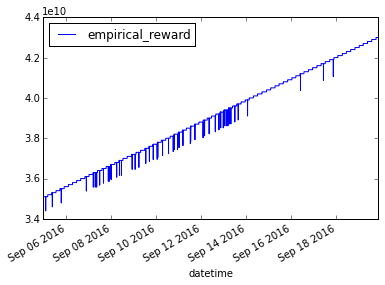

In [25]:
cb_df[cb_df.blockindex>40000].plot(x="datetime", y="empirical_reward")

In [24]:
cb_df[["blockindex", "empirical_reward"]]

,blockindex,empirical_reward
count,47959.000000,4.795900e+04
mean,23980.000000,1.929462e+10
std,13844.715117,1.343936e+10
min,1.000000,1.000000e+08
25%,11990.500000,7.000104e+09
50%,23980.000000,1.900014e+10
75%,35969.500000,3.100009e+10
max,47959.000000,4.300032e+10
